In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from tqdm import tqdm 
from collections import Counter
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_pickle("LSWMD.pkl")
df = df.drop(['waferIndex'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   trianTestLabel  811457 non-null  object 
 4   failureType     811457 non-null  object 
dtypes: float64(1), object(4)
memory usage: 31.0+ MB


In [2]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1

df['waferMapDim']=df.waferMap.apply(find_dim)

df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
445169,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot27301,[],[],"(32, 29)"
673937,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3031.0,lot41966,[[Test]],[[none]],"(54, 71)"
203309,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot12971,[],[],"(52, 59)"
794339,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2,...",562.0,lot46846,[[Test]],[[none]],"(29, 26)"
171651,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 2,...",533.0,lot10968,[],[],"(26, 26)"


In [3]:
def unwrap_nested_array(x):
    try:
        if isinstance(x, (list, np.ndarray)) and len(x) > 0:
            if isinstance(x[0], (list, np.ndarray)) and len(x[0]) > 0:
                return x[0][0]
    except:
        pass
    return None

# 문자열 추출
df['failureStr'] = df['failureType'].apply(unwrap_nested_array)
df['trainTestStr'] = df['trianTestLabel'].apply(unwrap_nested_array)

# 매핑 정의
mapping_type = {
    'Center': 0, 'Donut': 1, 'Edge-Loc': 2, 'Edge-Ring': 3,
    'Loc': 4, 'Random': 5, 'Scratch': 6, 'Near-full': 7, 'none': 8
}
mapping_traintest = {'Training': 0, 'Test': 1}

# 매핑 적용
df['failureNum'] = df['failureStr'].map(mapping_type)
df['trainTestNum'] = df['trainTestStr'].map(mapping_traintest)
df.drop(['failureStr', 'trainTestStr'], axis=1, inplace=True)
df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8.0,0.0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8.0,0.0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8.0,0.0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8.0,0.0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8.0,0.0


In [4]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = []

print("Preprocessing wafer maps...")

for i in tqdm(range(len(sub_df)), desc="Processing", unit="sample"):
    row = sub_df.iloc[i, :]

    # skip null label
    if len(row['failureType']) == 0:
        continue

    # wafer image 추가
    sw = np.concatenate((sw, row['waferMap'].reshape(1, 26, 26)))

    # 라벨 추가
    label.append(row['failureType'][0][0])  # numpy.ndarray 구조 대응

# 최종 배열 생성
x = sw[1:]
y = np.array(label).reshape((-1, 1))

print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

Preprocessing wafer maps...


Processing: 100%|██████████| 30078/30078 [01:17<00:00, 390.20sample/s]  

x shape : (14366, 26, 26), y shape : (14366, 1)


In [5]:
label_counts = Counter([lbl.item() for lbl in y])
min_samples = 2  # 최소 개수 기준

# 제외할 클래스 찾기
valid_classes = [cls for cls, count in label_counts.items() if count >= min_samples]

# 필터링
keep_indices = [i for i, y in enumerate(y) if y.item() in valid_classes]
x = x[keep_indices]
y = y[keep_indices]

class_counts = Counter([y.item() for y in y])
print("🔢 클래스별 개수:")
for cls, count in sorted(class_counts.items()):
    print(f"Class {cls}: {count}개")

🔢 클래스별 개수:
Class Center: 90개
Class Edge-Loc: 296개
Class Edge-Ring: 31개
Class Loc: 297개
Class Near-full: 16개
Class Random: 74개
Class Scratch: 72개
Class none: 13489개


In [6]:
bin_map = {-1: 0, 0: 1, 1: 2} 

new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            b = int(x[w, i, j])
            if b in bin_map:
                new_x[w, i, j, bin_map[b]] = 1

print('new_x shape : {}'.format(new_x.shape))

new_x shape : (14365, 26, 26, 3)


In [7]:
label_mapping = {
    'Center': 0, 'Edge-Loc': 1, 'Edge-Ring': 2,
    'Loc': 3, 'Random': 4, 'Scratch': 5, 'Near-full': 6, 'none': 7
}

y_int = [label_mapping[label[0]] for label in y]  
y_tensor = torch.tensor(y_int, dtype=torch.long) 
x_tensor = torch.tensor(np.transpose(new_x, (0, 3, 1, 2)), dtype=torch.float32)  
class_names = [name for name, _ in sorted(label_mapping.items(), key=lambda x: x[1])]

In [8]:
class SimpleCNNClassifier(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        self.feature_map = x
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [9]:
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

        self.attn_weights = None  

    def forward(self, src):
        # 반드시 average_attn_weights=False 로 해야 [B, heads, T, T]
        attn_output, attn_weights = self.self_attn(
            src, src, src, need_weights=True, average_attn_weights=False
        )
        self.attn_weights = attn_weights  # 🔥 여기 꼭 실행되어야 함

        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        ff = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff)
        src = self.norm2(src)
        return src


class ViT(nn.Module):
    def __init__(self, image_size=26, patch_size=2, num_classes=8,
                 embed_dim=64, num_heads=4, num_layers=4):
        super().__init__()
        assert image_size % patch_size == 0
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = 3 * patch_size * patch_size

        self.patch_embed = nn.Linear(self.patch_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, embed_dim))

        self.encoder_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(embed_dim, num_heads, embed_dim * 2)
            for _ in range(num_layers)
        ])

        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B, C, H, W = x.shape
        p = self.patch_size
        x = x.unfold(2, p, p).unfold(3, p, p)
        x = x.permute(0, 2, 3, 1, 4, 5).reshape(B, -1, C * p * p)
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, 1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed

        for layer in self.encoder_layers:
            x = layer(x)

        self.last_attn = self.encoder_layers[-1].attn_weights
        return self.fc(x[:, 0])



In [10]:
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, dim_feedforward):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.dropout = nn.Dropout(0.1)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

        self.attn_weights = None

    def forward(self, src):
        attn_output, attn_weights = self.self_attn(
            src, src, src, need_weights=True, average_attn_weights=False
        )
        self.attn_weights = attn_weights  

        src = src + self.dropout1(attn_output)
        src = self.norm1(src)

        ff = self.linear2(self.dropout(F.relu(self.linear1(src))))
        src = src + self.dropout2(ff)
        src = self.norm2(src)
        return src

class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes=8, embed_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, embed_dim, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((7, 7))  

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.encoder_layers = nn.ModuleList([
            CustomTransformerEncoderLayer(embed_dim, num_heads, embed_dim * 2)
            for _ in range(num_layers)
        ])

        self.fc = nn.Linear(embed_dim, num_classes)
        self.last_attn = None

    def forward(self, x):
        x = F.relu(self.conv1(x))      
        x = F.relu(self.conv2(x))      
        x = F.relu(self.conv3(x))       
        x = self.pool(x)              

        B, C, H, W = x.shape
        x = x.view(B, C, H * W).permute(0, 2, 1) 
        cls = self.cls_token.expand(B, 1, -1)    
        x = torch.cat([cls, x], dim=1)          

        for layer in self.encoder_layers:
            x = layer(x)

        self.last_attn = self.encoder_layers[-1].attn_weights
        return self.fc(x[:, 0])

In [11]:
def evaluate_model(model, dataloader, device, class_names=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch).argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    print(f"\n Overall Evaluation")
    print(f"Accuracy : {acc:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall   : {recall:.4f}")
    print(f"Macro F1-score : {f1:.4f}")

    print(f"\n Per-Class Evaluation:")
    num_classes = len(per_class_precision)
    for i in range(num_classes):
        class_label = class_names[i] if class_names else f"Class {i}"
        print(f"{class_label:<10} | Precision: {per_class_precision[i]:.4f}  "
              f"Recall: {per_class_recall[i]:.4f}  F1-score: {per_class_f1[i]:.4f}")


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
def train_and_evaluate_base(x_tensor, y_tensor, num_classes=9, epochs=40, batch_size=64, val_ratio=0.2, mode = 'cnn', device=device):

    train_idx, val_idx = train_test_split(
    np.arange(len(y_tensor)),
    test_size=val_ratio,
    stratify=y_tensor.numpy(),  
    random_state=42)
    x_train, y_train = x_tensor[train_idx], y_tensor[train_idx]
    x_val, y_val = x_tensor[val_idx], y_tensor[val_idx]


    x_train, y_train = x_tensor[train_idx], y_tensor[train_idx]
    x_val, y_val = x_tensor[val_idx], y_tensor[val_idx]

    train_dataset = TensorDataset(x_train, y_train)
    val_dataset = TensorDataset(x_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    if mode == 'cnn':
        model = SimpleCNNClassifier(num_classes=num_classes).to(device)
    elif mode == 'vit':
        model = ViT(num_classes=num_classes).to(device)
    elif mode == 'hybrid':
        model = CNN_ViT_Hybrid(num_classes=num_classes).to(device)
        
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0011, weight_decay=1e-4)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch:02d}/{epochs} - Train Loss: {avg_loss:.4f}")

    print("\n Final Validation Evaluation:")
    evaluate_model(model, val_loader, device, class_names)

    return model, val_loader

In [14]:
def visualize_cnn_gradcam_per_class(model, samples, class_names, device):
    import cv2
    import matplotlib.pyplot as plt

    model.eval()
    n_classes = len(samples)
    fig, axes = plt.subplots(n_classes, 2, figsize=(8, 4 * n_classes))

    for i, (label, x) in enumerate(samples.items()):
        input_tensor = x.unsqueeze(0).to(device)
        input_tensor.requires_grad_()

        output = model(input_tensor)
        model.feature_map.retain_grad()
        model.zero_grad()
        target_score = output[0, label]
        target_score.backward()

        gradients = model.feature_map.grad[0]
        activations = model.feature_map[0].detach()
        pooled_grad = torch.mean(gradients, dim=[1, 2])
        cam = torch.sum(pooled_grad[:, None, None] * activations, dim=0)
        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)
        cam = cam.cpu().numpy()

        img = input_tensor[0].permute(1, 2, 0).detach().cpu().numpy()
        img = (img - img.min()) / (img.max() + 1e-8)
        cam_resized = cv2.resize(cam, (img.shape[1], img.shape[0]))

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f'Class: {class_names[label]} (Original)')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img)
        axes[i, 1].imshow(cam_resized, cmap='jet', alpha=0.5)
        axes[i, 1].set_title(f'Class: {class_names[label]} (Grad-CAM)')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


In [15]:
def visualize_vit_attention_per_class(model, samples, class_names, device):
    import cv2
    import matplotlib.pyplot as plt

    model.eval()
    n_classes = len(samples)
    fig, axes = plt.subplots(n_classes, 2, figsize=(8, 4 * n_classes))

    for i, (label, x) in enumerate(samples.items()):
        input_tensor = x.unsqueeze(0).to(device)
        with torch.no_grad():
            _ = model(input_tensor)
            attn = model.last_attn

        if attn is not None and attn.dim() == 4:
            mean_attn = attn[0].mean(0)  # [tokens, tokens]
            cls_attn = mean_attn[0, 1:]  # [num_patches]
            num_patches = int(cls_attn.shape[0] ** 0.5)
            attn_map = cls_attn.reshape(num_patches, num_patches).cpu().numpy()

            img = input_tensor[0].permute(1, 2, 0).detach().cpu().numpy()
            img = (img - img.min()) / (img.max() + 1e-8)
            attn_resized = cv2.resize(attn_map, (img.shape[1], img.shape[0]))

            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Class: {class_names[label]} (Original)')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(img)
            axes[i, 1].imshow(attn_resized, cmap='jet', alpha=0.5)
            axes[i, 1].set_title(f'Class: {class_names[label]} (Attention)')
            axes[i, 1].axis('off')
        else:
            axes[i, 0].imshow(x.permute(1, 2, 0).cpu())
            axes[i, 0].set_title(f'Class: {class_names[label]} (Original)')
            axes[i, 0].axis('off')

            axes[i, 1].text(0.5, 0.5, 'No attention', ha='center', va='center')
            axes[i, 1].set_title(f'Class: {class_names[label]} (Attention)')
            axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [16]:
def collect_one_sample_per_class(val_loader, class_names, device):
    samples = {}  # label: image_tensor
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        for x, y in zip(images, labels):
            label = y.item()
            if label not in samples:
                samples[label] = x
            if len(samples) == len(class_names):
                return samples
    return samples


In [17]:
batch = 128
num_epoch = 70
num_classes = 8
num_iter = 1

Epoch 01/70 - Train Loss: 0.4389
Epoch 02/70 - Train Loss: 0.2879
Epoch 03/70 - Train Loss: 0.2579
Epoch 04/70 - Train Loss: 0.2422
Epoch 05/70 - Train Loss: 0.2250
Epoch 06/70 - Train Loss: 0.2129
Epoch 07/70 - Train Loss: 0.1940
Epoch 08/70 - Train Loss: 0.1804
Epoch 09/70 - Train Loss: 0.1727
Epoch 10/70 - Train Loss: 0.1596
Epoch 11/70 - Train Loss: 0.1576
Epoch 12/70 - Train Loss: 0.1470
Epoch 13/70 - Train Loss: 0.1403
Epoch 14/70 - Train Loss: 0.1320
Epoch 15/70 - Train Loss: 0.1308
Epoch 16/70 - Train Loss: 0.1237
Epoch 17/70 - Train Loss: 0.1212
Epoch 18/70 - Train Loss: 0.1134
Epoch 19/70 - Train Loss: 0.1190
Epoch 20/70 - Train Loss: 0.1122
Epoch 21/70 - Train Loss: 0.1069
Epoch 22/70 - Train Loss: 0.1070
Epoch 23/70 - Train Loss: 0.1027
Epoch 24/70 - Train Loss: 0.1008
Epoch 25/70 - Train Loss: 0.1015
Epoch 26/70 - Train Loss: 0.1038
Epoch 27/70 - Train Loss: 0.0981
Epoch 28/70 - Train Loss: 0.0942
Epoch 29/70 - Train Loss: 0.0944
Epoch 30/70 - Train Loss: 0.0916
Epoch 31/7

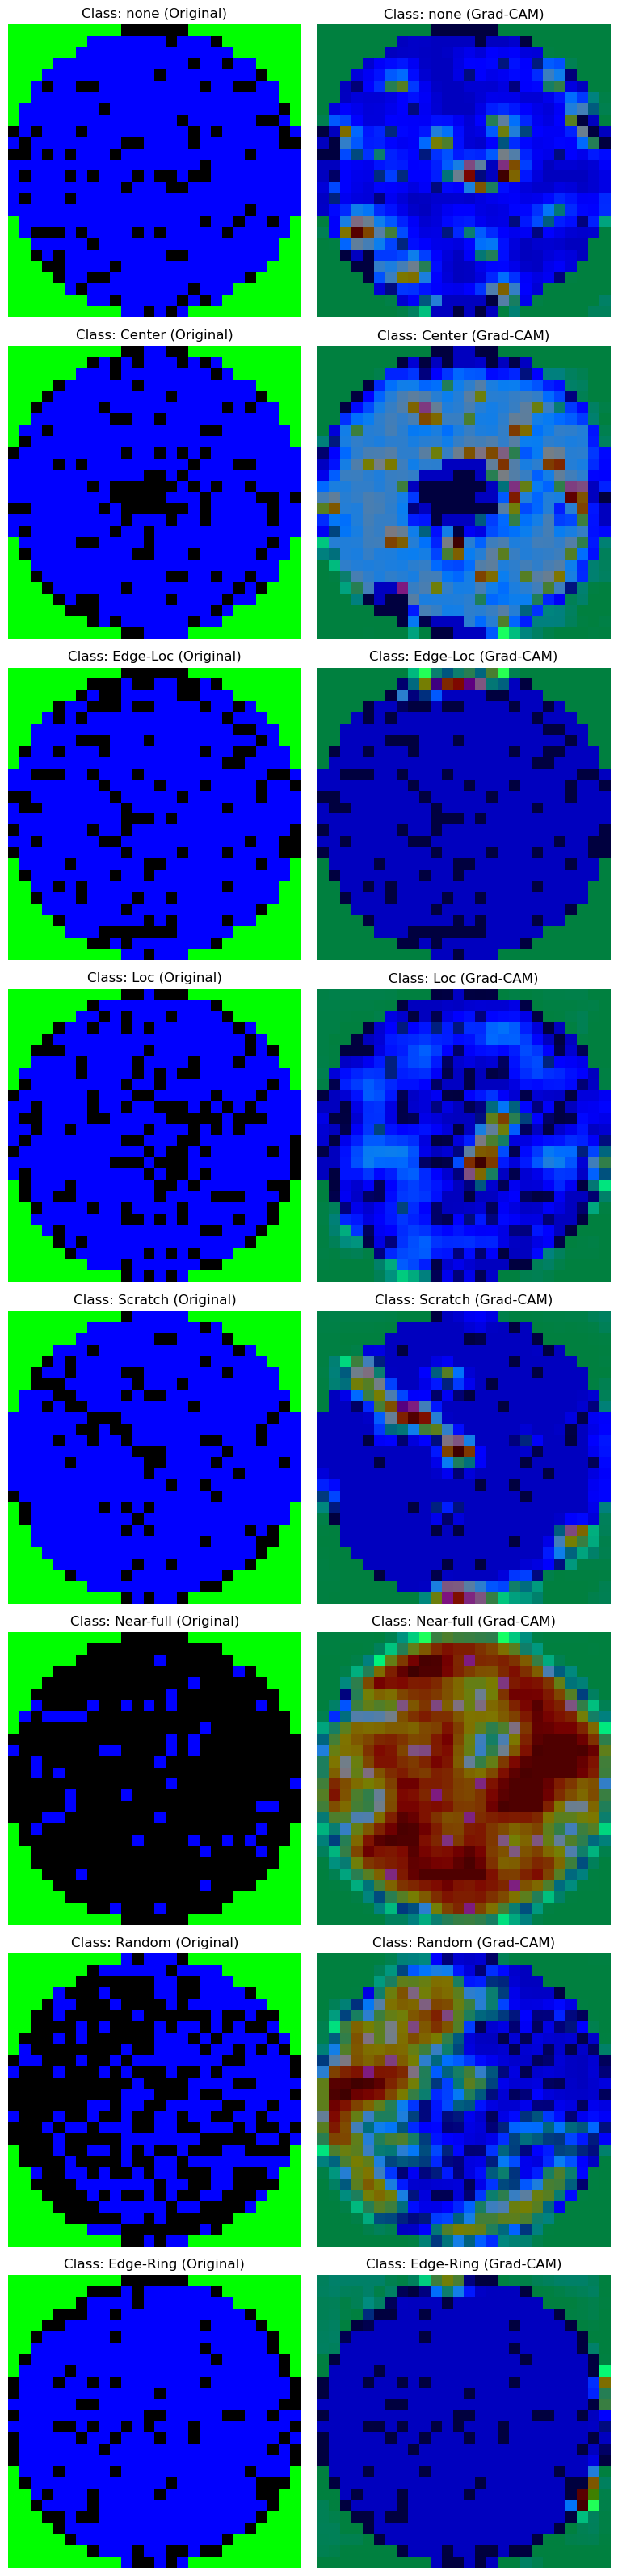

Evaluating CNN model...


In [28]:
cnn_model, val_loader = train_and_evaluate_base(x_tensor, y_tensor, num_classes=num_classes, epochs=num_epoch, batch_size = batch, mode = 'cnn')
samples  = collect_one_sample_per_class(val_loader, class_names, device)
visualize_cnn_gradcam_per_class(cnn_model, samples, class_names, device)
print("Evaluating CNN model...")

Epoch 01/70 - Train Loss: 0.3692
Epoch 02/70 - Train Loss: 0.3279
Epoch 03/70 - Train Loss: 0.3229
Epoch 04/70 - Train Loss: 0.2650
Epoch 05/70 - Train Loss: 0.2450
Epoch 06/70 - Train Loss: 0.2214
Epoch 07/70 - Train Loss: 0.2145
Epoch 08/70 - Train Loss: 0.2029
Epoch 09/70 - Train Loss: 0.1906
Epoch 10/70 - Train Loss: 0.1833
Epoch 11/70 - Train Loss: 0.1711
Epoch 12/70 - Train Loss: 0.1589
Epoch 13/70 - Train Loss: 0.1488
Epoch 14/70 - Train Loss: 0.1419
Epoch 15/70 - Train Loss: 0.1332
Epoch 16/70 - Train Loss: 0.1389
Epoch 17/70 - Train Loss: 0.1245
Epoch 18/70 - Train Loss: 0.1176
Epoch 19/70 - Train Loss: 0.1101
Epoch 20/70 - Train Loss: 0.1057
Epoch 21/70 - Train Loss: 0.1013
Epoch 22/70 - Train Loss: 0.0994
Epoch 23/70 - Train Loss: 0.0975
Epoch 24/70 - Train Loss: 0.0883
Epoch 25/70 - Train Loss: 0.0864
Epoch 26/70 - Train Loss: 0.0784
Epoch 27/70 - Train Loss: 0.0736
Epoch 28/70 - Train Loss: 0.0667
Epoch 29/70 - Train Loss: 0.0680
Epoch 30/70 - Train Loss: 0.0672
Epoch 31/7

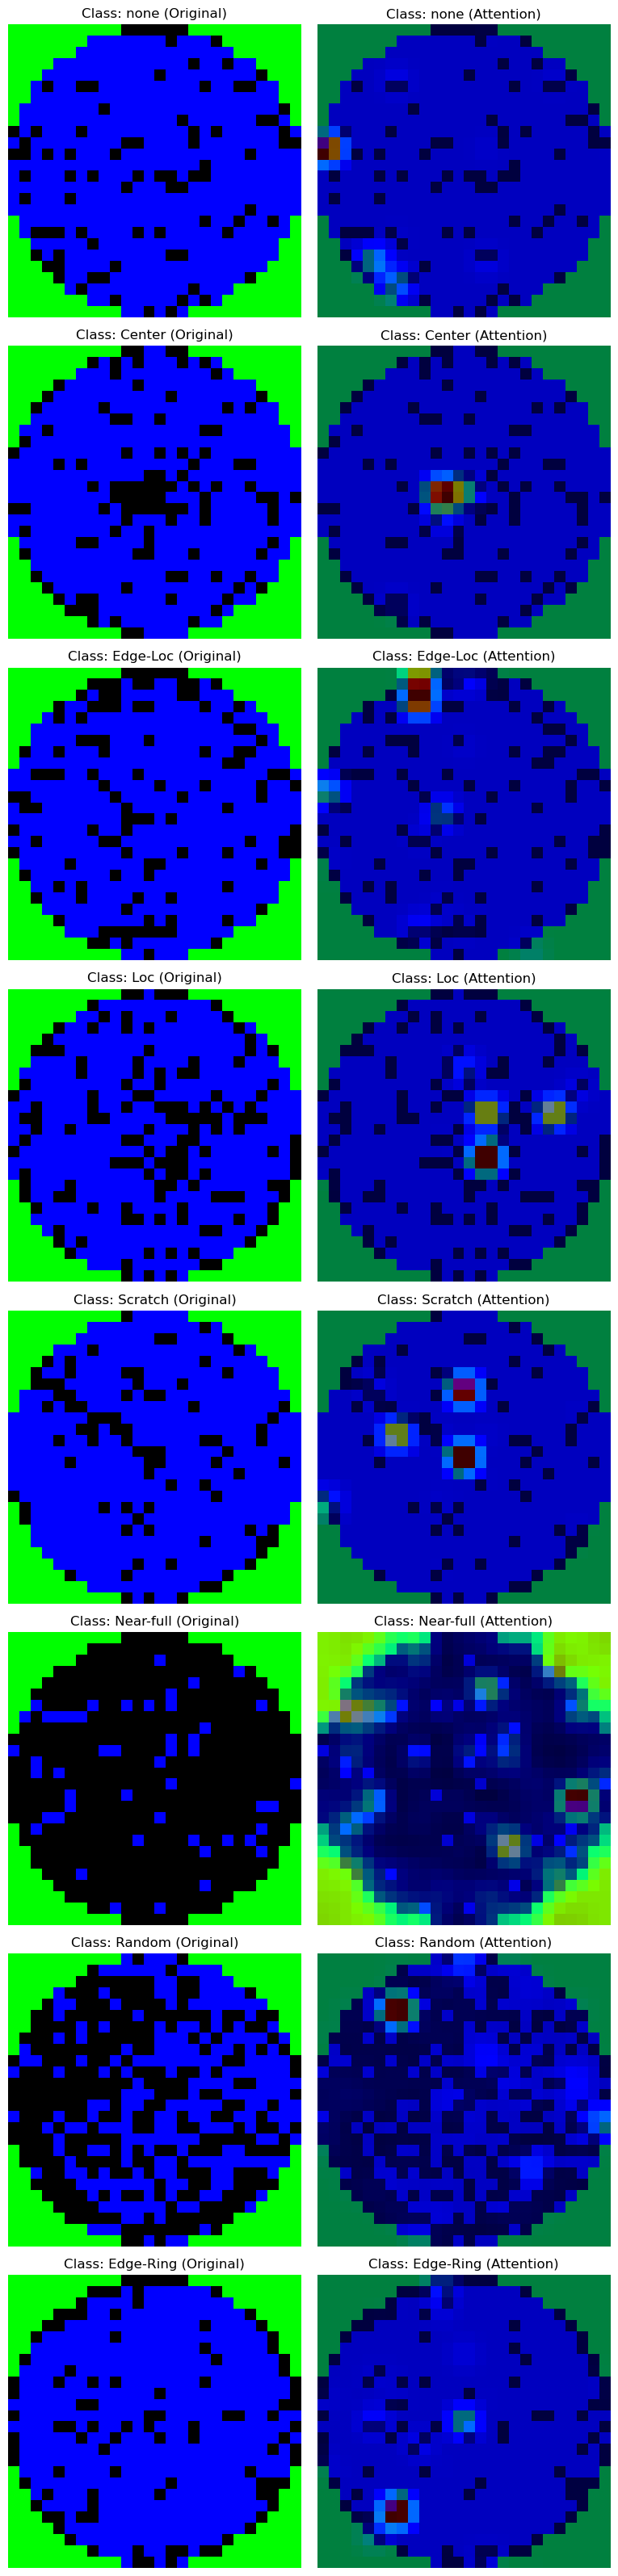

Evaluating ViT model...


In [32]:
vit_model, val_loader = train_and_evaluate_base(x_tensor, y_tensor, num_classes = num_classes, epochs=num_epoch, batch_size=batch, mode = 'vit')
visualize_vit_attention_per_class(vit_model, samples, class_names, device)
print("Evaluating ViT model...")

Epoch 01/70 - Train Loss: 0.3901
Epoch 02/70 - Train Loss: 0.3162
Epoch 03/70 - Train Loss: 0.3257
Epoch 04/70 - Train Loss: 0.2993
Epoch 05/70 - Train Loss: 0.1965
Epoch 06/70 - Train Loss: 0.1612
Epoch 07/70 - Train Loss: 0.1475
Epoch 08/70 - Train Loss: 0.1430
Epoch 09/70 - Train Loss: 0.1300
Epoch 10/70 - Train Loss: 0.1246
Epoch 11/70 - Train Loss: 0.1138
Epoch 12/70 - Train Loss: 0.1108
Epoch 13/70 - Train Loss: 0.0997
Epoch 14/70 - Train Loss: 0.0990
Epoch 15/70 - Train Loss: 0.0997
Epoch 16/70 - Train Loss: 0.0913
Epoch 17/70 - Train Loss: 0.0884
Epoch 18/70 - Train Loss: 0.0877
Epoch 19/70 - Train Loss: 0.0892
Epoch 20/70 - Train Loss: 0.0862
Epoch 21/70 - Train Loss: 0.0854
Epoch 22/70 - Train Loss: 0.0833
Epoch 23/70 - Train Loss: 0.0761
Epoch 24/70 - Train Loss: 0.0776
Epoch 25/70 - Train Loss: 0.0738
Epoch 26/70 - Train Loss: 0.0799
Epoch 27/70 - Train Loss: 0.0714
Epoch 28/70 - Train Loss: 0.0721
Epoch 29/70 - Train Loss: 0.0700
Epoch 30/70 - Train Loss: 0.0638
Epoch 31/7

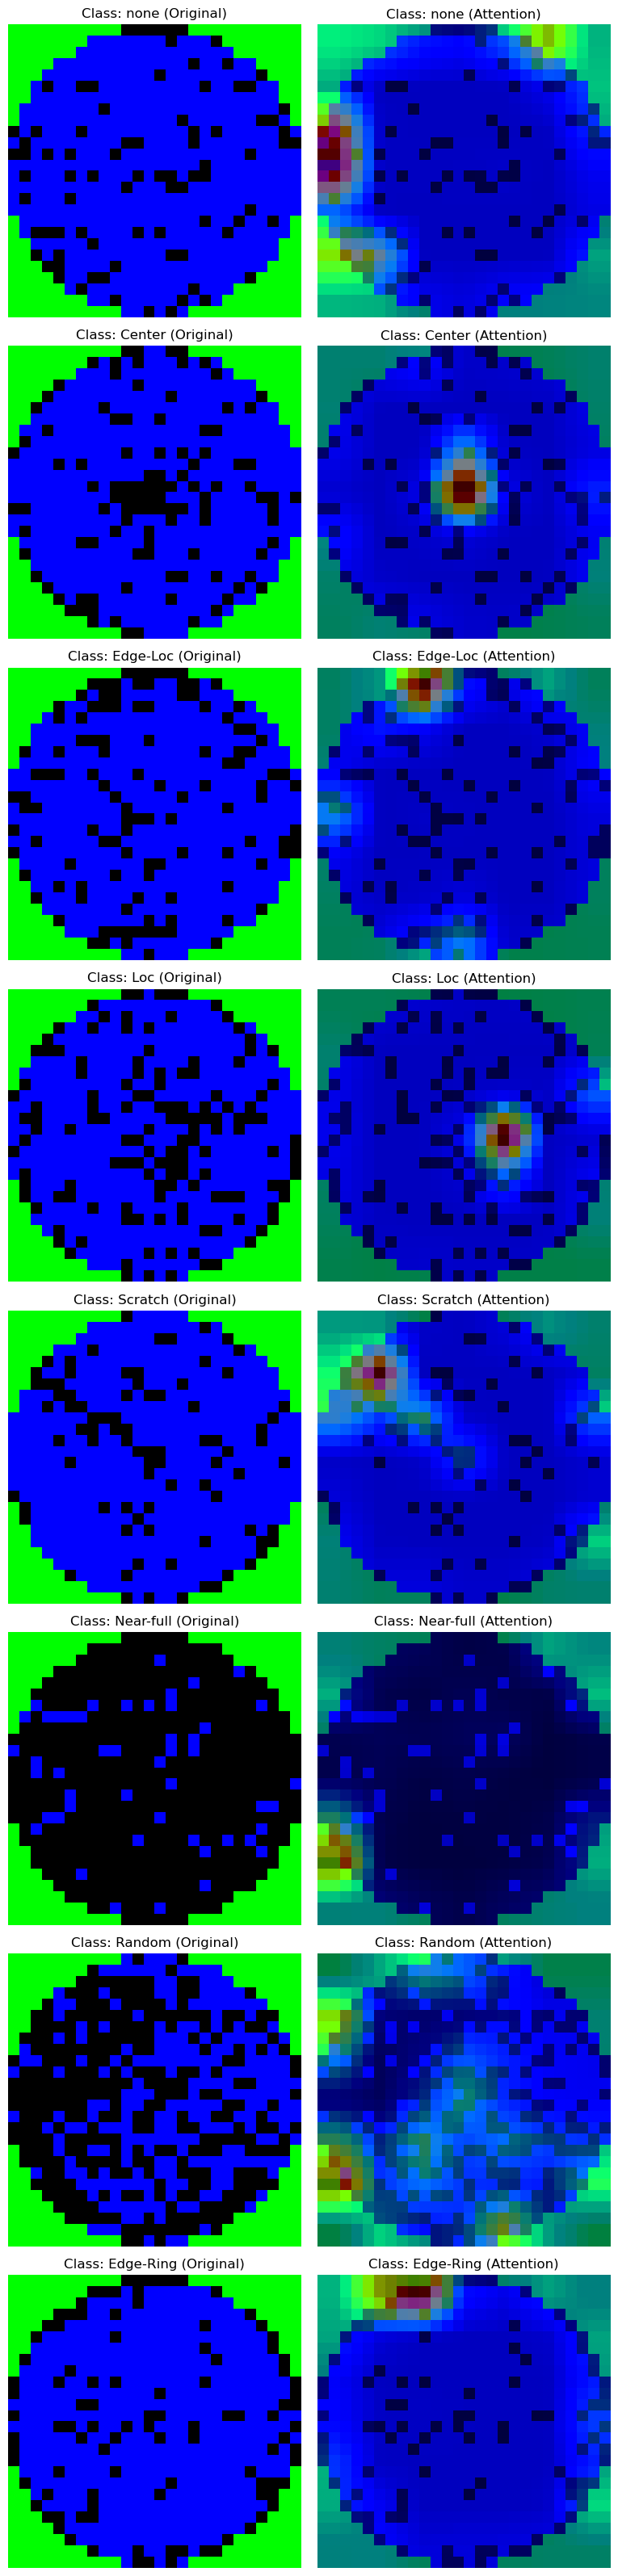

Evaluating hybrid model...


In [20]:
hybrid_model, val_loader = train_and_evaluate_base(x_tensor, y_tensor, num_classes=num_classes, epochs=num_epoch, batch_size=batch, mode = 'hybrid')      
visualize_vit_attention_per_class(hybrid_model, samples, class_names, device)
print("Evaluating hybrid model...")

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

models = {
    "SimpleCNN": cnn_model,
    "ViT": vit_model,
    "CNN+ViT": hybrid_model
}

for name, model in models.items():
    total_params = count_parameters(model)
    print(f"{name:<10}: {total_params:,} trainable parameters")

SimpleCNN : 151,624 trainable parameters
ViT       : 146,184 trainable parameters
CNN+ViT   : 123,848 trainable parameters
